<a href="https://colab.research.google.com/github/MElena14/COMP341/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### imports

In [ ]:
import random
import math
from collections import deque,namedtuple
import cv2
import pickle
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

import gym


In [ ]:
# HIDE OUTPUT
!wget http://www.atarimania.com/roms/Roms.rar 
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

--2022-04-18 17:46:53--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  18.68M   734KB/s    in 27s     

2022-04-18 17:47:20 (716 KB/s) - ‘Roms.rar’ saved [19583716/19583716]



#### Render OpenAI Gym Environments from CoLab

In [ ]:
# HIDE OUTPUT
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"possible actions: {env.unwrapped.get_action_meanings()}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")
  
query_environment("Atlantis-v0")

Action Space: Discrete(4)
possible actions: ['NOOP', 'FIRE', 'RIGHTFIRE', 'LEFTFIRE']
Observation Space: Box(0, 255, (128,), uint8)
Max Episode Steps: 10000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


In [ ]:
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### inital random agent

In [ ]:
env = wrap_env(gym.make("Atlantis-v0"))

observation = env.reset()
score = 0
while True:
    env.render()
    
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
    score += reward
    if done:
      print(f"finished! random agent's score is {score}")
      break

env.close()
show_video()

finished! random agent's score is 17100.0


#### Deep QN

In [ ]:
class DQNCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential( # in = 84x84
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        ) # out = 7x7
        self.feature_size = 7 * 7 * 64

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

#### utils

In [ ]:
# taken from https://github.com/deepanshut041/Reinforcement-Learning/blob/master/algos/preprocessing/stack_frame.py
def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (0, -1, -70, 0), 84)
    frames = stack_frame(frames, frame, is_new)
    return frames

### memory

In [1]:
class ReplayMemory:
    def __init__(self, buffer_size, batch_size, device, filename=None):
        self.memory = deque(maxlen=buffer_size) if filename != None else pickle.load(open(filename, 'r'))
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        if e is not None:
            self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return (states, actions, rewards, next_states, dones)

    def save(self, filename):
        filehandler = open(filename, 'w') 
        pickle.dump(self.memory, filehandler)

    def __len__(self):
        return len(self.memory)

### Agent

In [2]:
class DQNAgent:
    def __init__(self, args):
        """
        args = {
            input_shape:  (tuple) dimension of each state (C, H, W)
            action_size (int): dimension of each action
            seed (int): random seed
            device(string): Use Gpu or CPU
            buffer_size (int): replay buffer size
            batch_size (int):  torch minibatch size
            gamma (float): discount factor
            lr (float): learning rate 
            update_every (int): how often to update the network
            replay_after (int): After which replay to be started
            model(Model): Pytorch Model
            base_filename (str): base filename to save models to
        }
        """
        self.input_shape = args['input_shape']
        self.action_size = args['action_size']
        self.device = args['device']
        self.buffer_size = args['buffer_size']
        self.batch_size = args['batch_size']
        self.gamma = args['gamma']
        self.lr = args['lr']
        self.update_every = args['update_every']
        self.replay_after = args['replay_after']
        self.network = args['model']
        self.tau = args['tau']
        self.base_filename = args['base_filename']

        
        # Q-Network
        self.policy_net: torch.nn.Module = self.network(self.input_shape, self.action_size).to(self.device)
        self.target_net = self.network(self.input_shape, self.action_size).to(self.device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        # Replay memory
        self.memory = ReplayMemory(self.buffer_size, self.batch_size, self.device)
        
        self.time_step = 0

    def save(self):
        torch.save(self.policy_net.state_dict(), f"{self.base_filename}.policy.net")
        torch.save(self.target_net.state_dict(), f"{self.base_filename}.target.net")
        self.memory.save(f"{self.base_filename}.memory")

    def load(self):
        self.memory = ReplayMemory(self.buffer_size, self.batch_size, self.device, f"{self.base_filename}.memory")
        self.policy_net.load_state_dict(torch.load(f"{self.base_filename}.policy.net"))
        self.target_net.load_state_dict(torch.load(f"{self.base_filename}.target.net"))

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.time_step = (self.time_step + 1) % self.update_every

        if self.time_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.replay_after:
                experiences = self.memory.sample()
                self.learn(experiences)
                
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train() # set the model to training mode
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from the policy, and max predicted Q values from the target
        expected = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        targets_next = self.target_net(next_states).detach().max(1)[0]
        
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * targets_next * (1 - dones))

        # optimise the model, by minimising the loss
        loss = F.mse_loss(expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.policy_net, self.target_net, self.tau)

    
    # θ'=θ×τ+θ'×(1−τ)
    def soft_update(self, policy_model, target_model, tau):
        for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)

### train

In [ ]:
def epsilon_decrease_func(start, end, decay):
    def epsilon_decrease(i):
        return end + (start - end) * math.exp(-1. * i / decay)
    return epsilon_decrease

In [ ]:
def trainDQN(agent, epsilon_decreasem, n_episodes=1000, start_epoch = 0):
    scores = []
    for i_episode in range(start_epoch + 1, start_epoch + n_episodes + 1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_decrease(i_episode)
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores.append(score)
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores[-20:]) }', end="")
        
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores[-50:])}')
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
        if i_episode % 1000 == 0:
            agent.save()
    agent.save()
    return scores

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### run train

Episode 100	Average Score: 14734.0


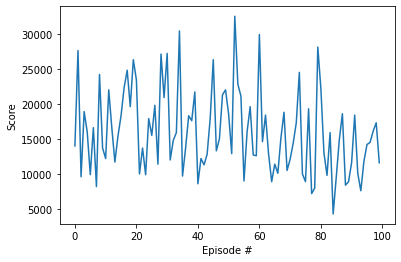

Episode 184	Average Score: 12180.0

In [ ]:
agent_args = {
            'input_shape': (4, 84, 84),
            'action_size': env.action_space.n,
            'device': device,
            'buffer_size': 100000,
            'batch_size': 64,
            'gamma': 0.99,
            'lr': 1e-4,
            'tau': 1e-3,
            'update_every': 1,
            'replay_after': 10000,
            'model': DQNCnn,
            'base_filename': 'atari_atlantas_models1'
        }

epsilon_decrease = epsilon_decrease_func(start=0.99, end=0.01, decay=100)
agent = DQNAgent(agent_args)
# agent.load()

scores = trainDQN(agent, epsilon_decrease, n_episodes=1000)

In [ ]:
def finalPlay(agent):
    score = 0
    state = stack_frames(None, env.reset(), True)
    while True:
        env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        score += reward
        state = stack_frames(state, next_state, False)
        if done:
            print("You Final score is:", score)
            break 
    env.close()
# finalPlay(agent)

### DQN2

In [ ]:
class DQN2(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        print("in size", x.size())
        x = F.relu(self.bn1(self.conv1(x)))
        print("2 size", x.size())
        x = F.relu(self.bn2(self.conv2(x)))
        print("3 size", x.size())
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [ ]:
class DQNtst(nn.Module):
    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        #in = 299x299
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=0), #out = 149x149
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0), #out = 147x147
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #out = 147x147
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 73x73                    
        )

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim)
                )
# (33600x3 and 210x64)
    def forward(self, x):
        x = x.to(device)
        print('in size=', x.size())
        x = self.block1(x)
        print('block1 size=', x.size())
        return self.linear(x)